# Summary
In this notebook mass differences are extracted from the AllPositive dataset and expressed per spectrum. This dataset is constructed here: https://github.com/iomega/spec2vec_gnps_data_analysis/tree/master/notebooks and the pickled gnps_positive_ionmode_cleaned_by_matchms_and_lookups file is created here: https://github.com/louwenjjr/improve_library_matching .

Steps in this notebook:
- Reading spectra
- Processing spectra
- Extracting mass differences (new) and fragments + neutral losses ('normal')

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

## Reading spectra

In [2]:
all_positive_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle"
if os.path.exists(all_positive_file):
    with open(all_positive_file, 'rb') as inf:
        spectrums = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

In [3]:
print("number of spectra:", len(spectrums))

number of spectra: 112956


## Processing spectra
Similar to Xing et al. (2020) https://pubs-acs-org.ezproxy.library.wur.nl/doi/full/10.1021/acs.analchem.0c02521
In Xing they also do square root transformation on the normalised intensities. We don't do that here (yet).

Steps:
- normalise peaks (maximum intensity to 1)
- remove peaks outside [0, 1000] m/z window
- select top 30 intensity peaks (from Xing et al. (2020))
- remove peaks with intensities < 0.001 of maximum intensity

In [14]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

# def post_process_s2v(s):
#     s = normalize_intensities(s)
#     s = select_by_mz(s, mz_from=0, mz_to=1000)
#     s = require_minimum_number_of_peaks(s, n_required=10)
#     s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
#     if s is None:
#         return None
#     s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
#     if len(s_remove_low_peaks.peaks) >= 10:
#         s = s_remove_low_peaks
        
#     s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
#     return s

# def post_process_md(s, min_peaks=10):
#     s = normalize_intensities(s)
#     s = select_by_mz(s, mz_from=0, mz_to=1000)
#     s = reduce_to_number_of_peaks(s, n_required=min_peaks, n_max=30)
#     if s is None:
#         return None
#     s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
#     if len(s_remove_low_peaks.peaks) >= min_peaks:
#         s = s_remove_low_peaks
#     return s

spectrums_top30 = []
spectrums_processed = []
min_peaks = 10
max_peaks = 30
for spec in spectrums:
    s = normalize_intensities(spec)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=min_peaks)
    s = reduce_to_number_of_peaks(s, n_required=min_peaks, ratio_desired=0.5)
    if s is None:
        continue
    #remove low peaks unless less than 10 peaks are left
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
    #split into two: 'normally' processed spectra and top30 for mass differences
    s_top30 = reduce_to_number_of_peaks(s, n_required=min_peaks, n_max=max_peaks)
    #add losses to normally processed spectra
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    
    spectrums_top30.append(s_top30)
    spectrums_processed.append(s)
    
    
    
# # apply post processing steps to the data
# spectrums_top30 = [post_process_md(s) for s in spectrums]

# # omit spectrums that didn't qualify for analysis
# spectrums_top30 = [s for s in spectrums_top30 if s is not None]

print("{} remaining spectra.".format(len(spectrums_top30)))
print("as a check: {} remaining spectra in normally processed data.".format(len(spectrums_processed)))

95320 remaining spectra.
as a check: 95320 remaining spectra in normally processed data.


In [19]:
spectrums_top30[-1].metadata["spectrum_id"] == spectrums_processed[-1].metadata["spectrum_id"]

True

In [20]:
# save top30 and normally processed file
top30_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_top30_peaks.pickle"
with open(top30_file, 'wb') as outf:
    pickle.dump(spectrums_top30, outf)
processed_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_processed.pickle"
with open(processed_file, 'wb') as outf:
    pickle.dump(spectrums_processed, outf)

In [21]:
# load top30 file
top30_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_top30_peaks.pickle"
if os.path.exists(top30_file):
    with open(top30_file, 'rb') as inf:
        spectrums_top30 = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

In [2]:
# load processed file
processed_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_processed.pickle"
if os.path.exists(processed_file):
    with open(processed_file, 'rb') as inf:
        spectrums_processed = pickle.load(inf)  # list of matchms.Spectrum.Spectrum
else:
    print("error")

In [23]:
spec0 = spectrums_top30[0]
[i for i in spec0.peaks]

[array([456.107544, 469.872314, 515.922852, 538.003174, 539.217773,
        554.117432, 556.030396, 582.110107, 599.352783, 600.382812,
        696.332397, 724.081909, 830.409302, 839.455811, 847.433594,
        851.380859, 852.370605, 866.295654, 868.372192, 909.424438,
        919.39624 , 932.351929, 936.552002, 939.61792 , 949.370239,
        953.396606, 954.491577, 963.686768, 964.524658, 965.192139]),
 array([0.13785328, 0.1145734 , 0.10302372, 0.28900242, 0.35616456,
        0.09970269, 0.28046377, 0.13351462, 1.        , 0.14946182,
        0.15854461, 0.11577153, 0.13417909, 0.09418422, 0.2569733 ,
        0.32199162, 0.36216307, 0.14520426, 0.10205448, 0.31933114,
        0.11226477, 0.17874806, 0.13489457, 0.10109441, 0.1117298 ,
        0.71323034, 0.16211023, 0.34214536, 0.41616014, 0.16272238])]

## Create SpectrumDocuments from normally processed Spectrums

In [3]:
from spec2vec import SpectrumDocument
documents_spectrums_processed = [SpectrumDocument(s, n_decimals=2) for s in spectrums_processed]

In [5]:
print(len(documents_spectrums_processed))

95320


In [4]:
# save SpectrumDocuments from normally processed spectra
documents_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_processed_documents.pickle"
with open(documents_file, 'wb') as outf:
    pickle.dump(documents_file, outf)

## Get mass differences
Mass differences are sorted on size, a cutoff of 36 is used and a maximum of 100 mass differences are extracted.

In [24]:
from matchms.Spikes import Spikes
from matchms.typing import SpectrumType

def get_mass_differences(spectrum_in: SpectrumType, cutoff: int = 36, n_max: int = 100) -> Spikes:
    """Returns Spikes with top 100 mass differences and intensities
    
    Parameters:
    spectrum_in:
        Spectrum in matchms.Spectrum format
    cutoff:
        Mass cutoff for mass difference (like Xing et al.)
    n_max:
        Maximum amount of mass differences to select, ranked on intensity (like Xing et al.)
    """
    if spectrum_in is None:
        return None

    spectrum = spectrum_in.clone()
    peaks_mz, peaks_intensities = spectrum.peaks
    mass_diff_mz = []
    mass_diff_intensities = []
    for i, (mz_i, int_i) in enumerate(zip(peaks_mz[:-1], peaks_intensities[:-1])):
        for mz_j, int_j in zip(peaks_mz[i+1:], peaks_intensities[i+1:]):
            mz_diff = mz_j-mz_i
            if mz_diff > cutoff:
                mass_diff_mz.append(mz_diff)
                mass_diff_intensities.append(np.mean([int_i, int_j]))
    mass_diff_mz = np.array(mass_diff_mz)
    mass_diff_intensities = np.array(mass_diff_intensities)
    idx = mass_diff_intensities.argsort()[-n_max:]
    idx_sort_by_mz = mass_diff_mz[idx].argsort()
    mass_diff_peaks = Spikes(mz=mass_diff_mz[idx][idx_sort_by_mz],
                             intensities=mass_diff_intensities[idx][idx_sort_by_mz])
    return mass_diff_peaks


In [25]:
get_mass_differences(spectrums_top30[0])[:]

[array([ 43.322387,  43.972168,  45.128418,  45.235351,  54.26233 ,
         55.10022 ,  57.053833,  58.043579,  60.13501 ,  61.165039,
         61.349609,  61.990844,  79.981324,  80.97107 ,  83.429931,
         85.024414,  87.100952,  96.152466,  96.979614,  98.229004,
        101.026001, 102.015747, 102.120972, 105.963012, 111.316163,
        112.154053, 112.305909, 112.821534, 113.143799, 113.940795,
        116.253174, 117.091064, 122.987304, 124.729126, 125.068847,
        129.480469, 134.115356, 143.245239, 156.038208, 157.114624,
        229.314697, 231.056519, 240.103028, 240.442749, 248.080811,
        251.987793, 252.028076, 253.017822, 257.064209, 266.942871,
        268.192261, 269.019409, 291.403198, 295.350463, 296.340209,
        308.215821, 309.43042 , 310.071655, 312.163086, 313.152832,
        313.377685, 314.367431, 320.043457, 327.077881, 332.999146,
        337.199219, 340.265137, 350.017456, 353.013794, 353.394042,
        354.043823, 355.138794, 364.141846, 364.

In [26]:
mass_differences = []
for spec in spectrums_top30:
    mass_differences.append(get_mass_differences(spec))  # list of Spikes

In [27]:
# save mass differences file
mass_differences_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_top30_mass_differences.pickle"
with open(mass_differences_file, 'wb') as outf:
    pickle.dump(mass_differences, outf)

In [12]:
len(mass_differences)

95320

In [6]:
# load mass differences file
mass_differences_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_top30_mass_differences.pickle"
if os.path.exists(mass_differences_file):
    with open(mass_differences_file, 'rb') as inf:
        mass_differences = pickle.load(inf) # list of Spikes
    print(len(mass_differences))
else:
    print("error")

95320


## Bin mass differences
Bin mass differences on 2 decimals to start.

In [59]:
mass_differences_2dec = []
n_decimals = 2
for mz, intensity in mass_differences:
    mz_round_str = [f"{mz_i:.{n_decimals}f}" for mz_i in mz]
    mass_differences_2dec.append(mz_round_str)

In [73]:
total_mass_differences_2dec = [md_mz for mds in mass_differences_2dec for md_mz in mds]
unique_mass_differences_2dec = set(total_mass_differences_2dec)

print(f"{len(total_mass_differences_2dec)} total mass differences 2 dec. On average \
{len(total_mass_differences_2dec)/len(mass_differences_2dec)} per spectrum")
print(f"{len(unique_mass_differences_2dec)} unique mass differences 2 dec")

8867097 total mass differences 2 dec. On average 93.02451741502308 per spectrum
77142 unique mass differences 2 dec


In [83]:
# find out about same mds in one spectrum, read '1: 7079085' as there are 7079085 times a mass difference instance
# occurs in a spectrum on their own, 2: 609235 as there are 609235 times there are two the same mds in a spectrum
# which represents 609235*2 md instances, etc.
from collections import Counter
counts = Counter()
for mds in mass_differences_2dec:
    counts.update(Counter(mds).values())
counts

Counter({1: 7079085,
         2: 609235,
         3: 102737,
         4: 31861,
         7: 2504,
         5: 11658,
         6: 5205,
         10: 356,
         12: 71,
         8: 1337,
         31: 2,
         34: 1,
         13: 30,
         9: 796,
         14: 21,
         22: 5,
         17: 15,
         15: 13,
         20: 13,
         66: 1,
         28: 2,
         16: 15,
         18: 8,
         11: 151,
         25: 2,
         23: 5,
         24: 4,
         32: 2,
         27: 1,
         19: 9,
         21: 5,
         36: 1,
         30: 2,
         43: 1,
         33: 1})

## Bin on 2 decimals and represent mass difference spectrum 'document'
Each spectrum is for now a list of tuples: [(md_mz, [sorted_intensities], counts)]

Mass differences are binned here in 2decimals

In [15]:
from collections import defaultdict
md_documents = []
n_decimals = 2
for mz, intensities in mass_differences:
    mz_round_strs = [f"{mz_i:.{n_decimals}f}" for mz_i in mz]
    summary = defaultdict(list)
    for mz_round_str, intensity in zip(mz_round_strs, intensities):
        summary[mz_round_str].append(intensity)
    info_tup = [(key, sorted(vals, reverse=True), len(vals)) for key, vals in summary.items()]
    info_tup.sort(key=lambda x: x[2], reverse=True)
    md_documents.append(info_tup)

In [16]:
md_documents[-1]

[('42.01',
  [0.5471988748004223,
   0.29402995355896977,
   0.2587543370247674,
   0.22516196172866768,
   0.2077839057469171,
   0.16617782710753534],
  6),
 ('59.04',
  [0.5761449934414131,
   0.5326966093483293,
   0.2587576081945805,
   0.23731664927344326,
   0.22863482744069547],
  5),
 ('41.03',
  [0.2470403578484444,
   0.23869891380292435,
   0.1765487596317252,
   0.15585352588600665],
  4),
 ('47.04',
  [0.5449840777200273,
   0.2852612222181785,
   0.24647013982288252,
   0.17711897765728707],
  4),
 ('77.05',
  [0.48533922298738597,
   0.3998471368406299,
   0.2403520777868316,
   0.21999714372480905],
  4),
 ('45.02', [0.5441008316773419, 0.2686389512033266, 0.24152126638341553], 3),
 ('63.03', [0.23546214529813952, 0.23145718002118665, 0.1546009272206983], 3),
 ('65.05', [0.5332837959321212, 0.38246346970824074, 0.1888362280034232], 3),
 ('37.05', [0.4620896524367514, 0.24413892972377266], 2),
 ('39.99', [0.2754398324425121, 0.20904187223369797], 2),
 ('44.03', [0.24746

In [17]:
# save md documents
md_documents_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_mass_difference_documents.pickle"
with open(md_documents_file, 'wb') as outf:
    pickle.dump(md_documents, outf)

In [3]:
# load md documents
md_documents_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_mass_difference_documents.pickle"
if os.path.exists(md_documents_file):
    with open(md_documents_file, 'rb') as inf:
        md_documents = pickle.load(inf)  # list of list of tuples 'documents'
    print(len(md_documents))
else:
    print("error")

95320


## Some info per MD

In [4]:
from collections import defaultdict

# dict of {md: [count for how many times it occurs in spectrumA, etc.]}
per_md_counts = defaultdict(list)
for doc in md_documents:
    for tup in doc:
        per_md_counts[tup[0]].append(tup[2])
len(per_md_counts)

77142

[3, 7, 7, 3, 1, 4, 9, 8, 5, 3] 66


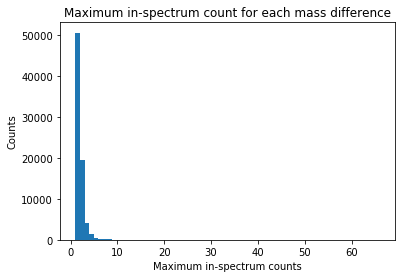

In [5]:
# summarise the highest in-spectrum-count for each MD
highest_count_per_md = [max(vals) for vals in per_md_counts.values()]
print(highest_count_per_md[:10], max(highest_count_per_md))
plt.hist(highest_count_per_md, bins = max(highest_count_per_md))
plt.title("Maximum in-spectrum count for each mass difference")
plt.xlabel("Maximum in-spectrum counts")
plt.ylabel("Counts")
plt.show()

In [6]:
# in how many spectra does a md occur (at least once)
md_spectrum_occurrences = {key:len(vals) for key, vals in per_md_counts.items()}
occurrences = md_spectrum_occurrences.values()
h_num = 25
highest_occ = sorted(occurrences)[-h_num:]
highest_mds = [(key,val) for key,val in md_spectrum_occurrences.items() if val in highest_occ]
print(f"highest {h_num} occurrences:\n" +\
      '\n'.join([f"{key}\t{val}"for key, val in sorted(highest_mds, key=lambda x: x[1], reverse=True)]))

highest 25 occurrences:
42.01	26113
40.03	22754
38.02	21033
42.05	18183
46.01	17565
52.03	17050
60.02	16476
54.05	16028
44.03	15649
43.99	14906
55.99	14106
50.02	13437
56.06	13416
80.06	12926
54.01	12850
59.01	12705
39.99	12509
36.02	12416
56.03	12292
80.03	11709
66.05	11541
59.04	10855
64.03	10750
74.04	10596
59.07	10357


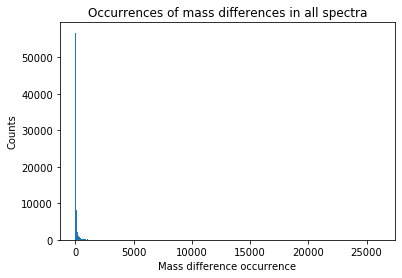

2738 mass differences occur in over 500 spectra


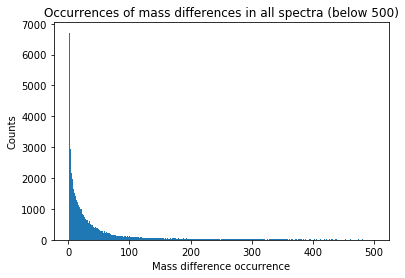

In [7]:
from collections import Counter
# summarise all occurrences
occurrence_counts = Counter(occurrences)
plt.subplots(0)
plt.hist(occurrences, bins = 500)
plt.title("Occurrences of mass differences in all spectra")
plt.xlabel("Mass difference occurrence")
plt.ylabel("Counts")
plt.show()

plt.subplots(1)
cut = 500
occurrences_below_cut = [occ for occ in occurrences if occ < cut]
print(f"{len(occurrences) - len(occurrences_below_cut)} mass differences occur in over {cut} spectra")
plt.hist(occurrences_below_cut, bins = cut)
plt.title(f"Occurrences of mass differences in all spectra (below {cut})")
plt.xlabel("Mass difference occurrence")
plt.ylabel("Counts")
plt.show()

In [8]:
occurrence_counts.most_common()

[(1, 6708),
 (2, 4205),
 (3, 2934),
 (4, 2520),
 (5, 2161),
 (6, 1955),
 (7, 1861),
 (8, 1658),
 (9, 1571),
 (10, 1521),
 (11, 1413),
 (12, 1387),
 (13, 1286),
 (15, 1232),
 (14, 1210),
 (16, 1133),
 (17, 1107),
 (18, 1057),
 (19, 1021),
 (20, 1013),
 (21, 988),
 (22, 862),
 (23, 846),
 (24, 809),
 (25, 791),
 (26, 750),
 (27, 710),
 (28, 685),
 (30, 663),
 (29, 652),
 (31, 633),
 (32, 618),
 (34, 604),
 (33, 547),
 (35, 531),
 (36, 522),
 (37, 485),
 (38, 483),
 (39, 470),
 (40, 438),
 (42, 435),
 (41, 412),
 (44, 399),
 (43, 382),
 (45, 377),
 (47, 369),
 (46, 368),
 (49, 353),
 (50, 341),
 (48, 324),
 (51, 321),
 (53, 315),
 (56, 295),
 (52, 290),
 (54, 284),
 (59, 274),
 (55, 263),
 (58, 257),
 (62, 241),
 (60, 224),
 (61, 220),
 (57, 218),
 (64, 218),
 (67, 214),
 (66, 207),
 (63, 199),
 (69, 198),
 (71, 184),
 (73, 183),
 (68, 179),
 (65, 177),
 (78, 169),
 (75, 164),
 (70, 161),
 (74, 155),
 (77, 153),
 (83, 146),
 (72, 146),
 (76, 139),
 (85, 138),
 (81, 135),
 (86, 134),
 (80,

In [27]:
occ_min = 5
occ_max = 500
num_md_occ_cutoff = sum(occurrence_counts.get(key) for key in range(occ_min, occ_max))
print(f"Number of mass differences that occur in between {occ_min} and {occ_max} spectra: {num_md_occ_cutoff}")

Number of mass differences that occur in between 5 and 500 spectra: 58037


## Filter out mass differences that occur outside of cutoff
keep MDs with occurrence between 5 and 500

In [10]:
occ_min = 5
occ_max = 500
black_list = set(md for md, occ in md_spectrum_occurrences.items() if occ < occ_min or occ >= occ_max)
print(f"{len(black_list)} MDs to filter out")

19105 MDs to filter out


In [11]:
md_documents_filtered = [[tup for tup in doc if tup[0] not in black_list] for doc in md_documents]

In [14]:
x=0
print(len(md_documents_filtered[x]), len(md_documents[x]))

#NB: some spectra become empty! like index -1
x=-1
print(len(md_documents_filtered[x]), len(md_documents[x]))

79 100
0 57


In [13]:
# save md documents filtered
md_documents_filtered_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_mass_difference_documents_filtered.pickle"
with open(md_documents_filtered_file, 'wb') as outf:
    pickle.dump(md_documents_filtered, outf)

In [2]:
# load md documents
md_documents_filtered_file = "/mnt/scratch/louwe015/Mass_differences/data/gnps_positive_ionmode_cleaned_by_matchms_and_lookups_mass_difference_documents_filtered.pickle"
if os.path.exists(md_documents_filtered_file):
    with open(md_documents_filtered_file, 'rb') as inf:
        md_documents_filtered = pickle.load(inf)  # list of list of tuples 'documents'
    print(len(md_documents_filtered))
else:
    print("error")

95320


## Plot same statistics again for filtered data

In [4]:
from collections import defaultdict

# dict of {md: [count for how many times it occurs in spectrumA, etc.]} for fitered data
per_md_counts_filtered = defaultdict(list)
for doc in md_documents_filtered:
    for tup in doc:
        per_md_counts_filtered[tup[0]].append(tup[2])
print("Number of mass differences left:", len(per_md_counts_filtered))

Number of mass differences left: 58037


[3, 7, 3, 1, 3, 1, 2, 2, 1, 2] 34


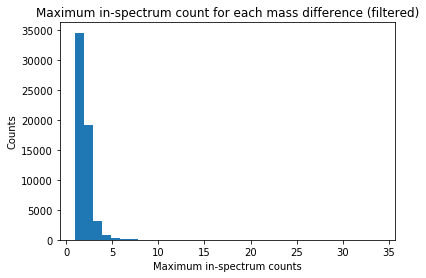

In [19]:
# summarise the highest in-spectrum-count for each MD filtered
highest_count_per_md_filtered = [max(vals) for vals in per_md_counts_filtered.values()]
print(highest_count_per_md_filtered[:10], max(highest_count_per_md_filtered))
plt.hist(highest_count_per_md_filtered, bins = max(highest_count_per_md_filtered))
plt.title("Maximum in-spectrum count for each mass difference (filtered)")
plt.xlabel("Maximum in-spectrum counts")
plt.ylabel("Counts")
plt.show()

In [5]:
# in how many spectra does a md occur (at least once) (filtered)
md_spectrum_occurrences_filtered = {key:len(vals) for key, vals in per_md_counts_filtered.items()}
occurrences_filtered = md_spectrum_occurrences_filtered.values()
h_num = 25
highest_occ_filtered = sorted(occurrences_filtered)[-h_num:]
highest_mds_filtered = [(key,val) for key,val in md_spectrum_occurrences_filtered.items() if val in highest_occ_filtered]
print(f"highest {h_num} occurrences:\n" +\
      '\n'.join([f"{key}\t{val}"for key, val in sorted(highest_mds_filtered, key=lambda x: x[1], reverse=True)]))

highest 25 occurrences:
157.02	499
136.10	499
147.98	499
152.09	499
85.24	499
224.23	499
223.16	498
104.93	498
90.09	498
156.00	498
282.18	498
176.10	497
204.11	497
165.98	497
139.98	497
108.13	497
266.23	497
310.27	497
143.84	497
153.02	496
182.14	496
360.32	496
165.00	496
138.02	496
256.13	496
382.31	496
338.36	496
342.31	496


In [6]:
md_spectrum_occurrences_filtered['157.02']

499

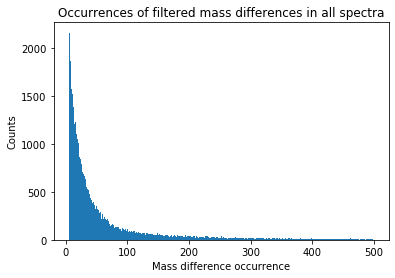

In [23]:
from collections import Counter
# summarise all occurrences filtered
occurrence_counts_filtered = Counter(occurrences_filtered)
plt.subplots(0)
plt.hist(occurrences_filtered, bins = 500-5)
plt.title("Occurrences of filtered mass differences in all spectra")
plt.xlabel("Mass difference occurrence")
plt.ylabel("Counts")
plt.show()

In [24]:
occurrence_counts_filtered.most_common()

[(5, 2161),
 (6, 1955),
 (7, 1861),
 (8, 1658),
 (9, 1571),
 (10, 1521),
 (11, 1413),
 (12, 1387),
 (13, 1286),
 (15, 1232),
 (14, 1210),
 (16, 1133),
 (17, 1107),
 (18, 1057),
 (19, 1021),
 (20, 1013),
 (21, 988),
 (22, 862),
 (23, 846),
 (24, 809),
 (25, 791),
 (26, 750),
 (27, 710),
 (28, 685),
 (30, 663),
 (29, 652),
 (31, 633),
 (32, 618),
 (34, 604),
 (33, 547),
 (35, 531),
 (36, 522),
 (37, 485),
 (38, 483),
 (39, 470),
 (40, 438),
 (42, 435),
 (41, 412),
 (44, 399),
 (43, 382),
 (45, 377),
 (47, 369),
 (46, 368),
 (49, 353),
 (50, 341),
 (48, 324),
 (51, 321),
 (53, 315),
 (56, 295),
 (52, 290),
 (54, 284),
 (59, 274),
 (55, 263),
 (58, 257),
 (62, 241),
 (60, 224),
 (61, 220),
 (57, 218),
 (64, 218),
 (67, 214),
 (66, 207),
 (63, 199),
 (69, 198),
 (71, 184),
 (73, 183),
 (68, 179),
 (65, 177),
 (78, 169),
 (75, 164),
 (70, 161),
 (74, 155),
 (77, 153),
 (83, 146),
 (72, 146),
 (76, 139),
 (85, 138),
 (81, 135),
 (86, 134),
 (80, 134),
 (82, 134),
 (89, 133),
 (84, 133),
 (79,

## Plot m/z of the filtered MDs

In [11]:
all_filtered_mds_mz = [float(key) for key in per_md_counts_filtered.keys()]

In [16]:
filtered_mds_mz, filtered_mds_occurences = zip(*[(float(key), val) for key, val in md_spectrum_occurrences_filtered.items()])

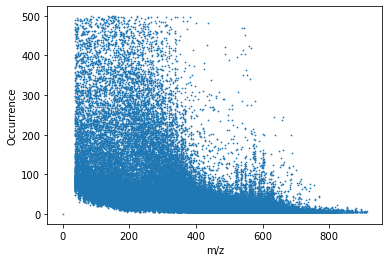

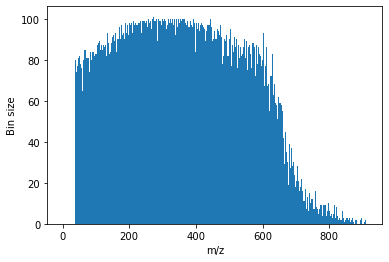

In [33]:
# mz versus occurrence
plt.scatter(filtered_mds_mz, filtered_mds_occurences, s=0.5)
plt.ylabel("Occurrence")
plt.xlabel("m/z")
plt.show()

plt.hist(filtered_mds_mz, bins = int(max(filtered_mds_mz)-min(filtered_mds_mz)))  # bin more or less on integers
plt.ylabel("Bin size")
plt.xlabel("m/z")
plt.show()